---

## 11.5 Beyond text classification: Sequence-to-sequence learning

TensorFlow [tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

In [1]:
import os
import re
import sys
import string
import random
import pathlib

import numpy as np
import tensorflow as tf

from tqdm import tqdm

from IPython.display import YouTubeVideo

### 11.5.1 A machine translation example

The attention mechanism originated in research in sequence to sequence with RNNs. The idea was to improve the hidden state of the generating RNN by allowing it to access (pay attention to) various parts of the source sequence at each step of the generation. Later on, the move was to remove the RNN mechanism altogether, and only use attention in both encoder and decoder.

<!-- <img style="height:700px" src="images/nlp/stanford.seq2seq.png"> -->
<img style="height:700px" src="https://github.com/jchwenger/AI/blob/main/lectures/06.more/images/nlp/stanford.seq2seq.png?raw=true">

<small>[Chris Manning, CS224N, Stanford](https://web.stanford.edu/class/cs224n/index.html), [lecture 7](https://web.stanford.edu/class/cs224n/slides/cs224n-2022-lecture07-nmt.pdf)  
The original paper: ["Sequence to Sequence Learning with Neural Networks"](https://arxiv.org/abs/1409.3215)</small>

<!-- <img src="images/nlp/seq2seq-nmt-model-fast.gif"> -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/06.more/images/nlp/seq2seq-nmt-model-fast.gif?raw=true">

<small>[Google seq2seq documentation](https://google.github.io/seq2seq/)</small>

### The Transformer: who *needs* RNNs anyway??

<!-- <img src="images/transformer/apply_the_transformer_to_machine_translation.gif"> -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/06.more/images/transformer/apply_the_transformer_to_machine_translation.gif?raw=true">

<small>["Neural machine translation with a Transformer and Keras", TensorFlow](https://www.tensorflow.org/text/tutorials/transformer)  
The paper: [Vaswani et al, "Attention Is All You Need"](https://arxiv.org/abs/1706.03762)</small>

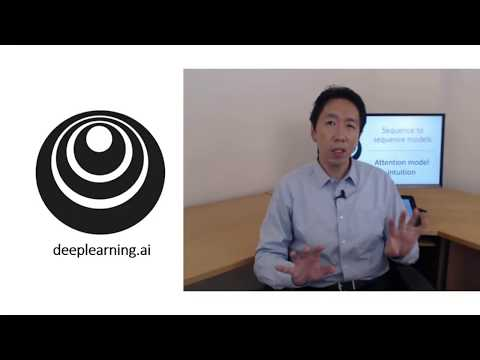

In [2]:
YouTubeVideo('SysgYptB198', width=853, height=480, start=2592) # C5W3L07 Attention Model Intuition

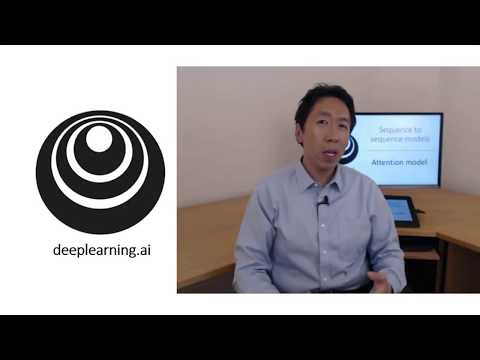

In [3]:
YouTubeVideo('quoGRI-1l0A', width=853, height=480, start=2592) # C5W3L08 Attention Model

### The Transformer applied to translation

### Download the dataset

In [4]:
DATASET_DIR = pathlib.Path("spa-eng")

if not DATASET_DIR.exists():
    !wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
    !unzip -q spa-eng.zip

--2024-09-09 22:15:18--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  2.06MB/s    in 1.2s    

2024-09-09 22:15:19 (2.06 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



Other languages available [here](https://www.manythings.org/anki/)!

In [5]:
TEXT_FILE = DATASET_DIR / "spa.txt"

with TEXT_FILE.open() as f:
    lines = f.read().strip().split("\n")

text_pairs = []
separator = "\t" if "\t" in lines[0] else " " # spa.txt is tab separated, but the other datasets use spaces

for line in tqdm(lines):
    english, spanish = line.split(separator)[:2] # for datasets other than the official one, only tak
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

100%|██████████| 118964/118964 [00:00<00:00, 805850.23it/s]


In [6]:
print(random.choice(text_pairs))

("Let's leave as soon as he gets back.", '[start] Vayámonos tan pronto como él vuelva. [end]')


In [7]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

#### Vectorizing the English and Spanish text pairs

In [8]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

#### Preparing datasets for the translation task

In [9]:
batch_size = 64 # my 6GB GPU can go up to 1560

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [10]:
for inputs, targets in train_ds:
    print(f"inputs['english'].shape: {inputs['english'].shape}, dtype: {inputs['english'].dtype}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}, dtype: {inputs['spanish'].dtype}")
    print(f"targets.shape: {targets.shape}, dtype: {targets.dtype}")
    break

inputs['english'].shape: (64, 20), dtype: <dtype: 'int64'>
inputs['spanish'].shape: (64, 20), dtype: <dtype: 'int64'>
targets.shape: (64, 20), dtype: <dtype: 'int64'>


---

### 11.5.2 Sequence-to-sequence learning with RNNs

#### GRU-based encoder

In [11]:
embed_dim = 256
latent_dim = 1024

source = tf.keras.Input(shape=(None,), dtype="int64", name="english")
x = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(latent_dim), merge_mode="sum"
)(x)

#### GRU-based decoder and the end-to-end model

In [12]:
past_target = tf.keras.Input(shape=(None,), dtype="int64", name="spanish")
x = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = tf.keras.layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = tf.keras.layers.Dropout(0.5)(x)
target_next_step = tf.keras.layers.Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = tf.keras.Model([source, past_target], target_next_step)

#### Training our recurrent sequence-to-sequence model

In [13]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
history = seq2seq_rnn.fit(train_ds, epochs=15,validation_data=val_ds)

Epoch 1/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 49s 33ms/step - accuracy: 0.1549 - loss: 5.2578 - val_accuracy: 0.1563 - val_loss: 3.8969
Epoch 2/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.1604 - loss: 3.8769 - val_accuracy: 0.1873 - val_loss: 3.2604
Epoch 3/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.1864 - loss: 3.3111 - val_accuracy: 0.2073 - val_loss: 2.8829
Epoch 4/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.2031 - loss: 2.9355 - val_accuracy: 0.2204 - val_loss: 2.6351
Epoch 5/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.2177 - loss: 2.6413 - val_accuracy: 0.2316 - val_loss: 2.4531
Epoch 6/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.2297 - loss: 2.4078 - val_accuracy: 0.2395 - val_loss: 2.3223
Epoch 7/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.2402 - loss: 2.2137 - val_accuracy: 0.2457 - val_loss: 2.2220
Epoch 8/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.2488 -

#### Translating new sentences with our RNN encoder and decoder

In [14]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence], verbose=0)
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

In [15]:
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20
test_eng_texts = [pair[0] for pair in test_pairs]

In [16]:
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Tom never smiles.
[start] tom nunca se ve [end]
-
Excuse me, I didn't catch your name.
[start] perdone no me tu nombre [end]
-
I barely even remember Tom.
[start] apenas me he dado tom [end]
-
We have had a bad time.
[start] hemos tenido mal tiempo [end]
-
You're incompetent.
[start] eres [UNK] [end]
-
Tom had a good teacher.
[start] tom tuvo un buen profesor [end]
-
Tom found out that his phone had been tapped.
[start] tom encontró que había perdido su billetera [end]
-
The wound left a scar on his arm.
[start] la herida le puso una cicatriz en el brazo [end]
-
Tom fed the neighbor's cat while they were away.
[start] tom se quitó los platos y el gato se había ido [end]
-
I think we'll be safe here.
[start] creo que estamos aquí para estar acá [end]
-
My roommate is crazy.
[start] mi compañero de habitación es [end]
-
They asked me to make a speech on short notice.
[start] me pidió que [UNK] un discurso más alto [end]
-
Don't change your mind.
[start] no [UNK] tu promesa [end]
-
The 

---

### 11.5.3 Sequence-to-sequence learning with Transformer

#### Putting it all together: A Transformer for machine translation

<!-- <img style="" src="images/transformer/the-annotated-transformer_14_0.transformer-full.png"> -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/06.more/images/transformer/the-annotated-transformer_14_0.transformer-full.png?raw=true">

<small>[Vaswani et al, "Attention Is All You Need"](https://arxiv.org/abs/1706.03762)</small>

#### The Transformer encoder

In [17]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim                               # parameters
        self.dense_dim = dense_dim
        self.num_heads = num_heads
    
    # new in Keras 3, see: https://keras.io/guides/making_new_layers_and_models_via_subclassing/#best-practice-deferring-weight-creation-until-the-shape-of-the-inputs-is-known
    def build(self, input_shape):
        self.attention = tf.keras.layers.MultiHeadAttention(     # multi-head attention layer
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential(                   # dense layer on top: like a nonlinearity
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()  # layer norm
        self.layernorm_2 = tf.keras.layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:                                     # optional mask
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask                  # only two inputs! Value is used as key as well
        )
        proj_input = self.layernorm_1(inputs + attention_output) # inputs + attn: residual connection
        proj_output = self.dense_proj(proj_input)                # dense layer on top: like a nonlinearity
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

#### The Transformer decoder

In [2]:
def get_causal_attention_mask(inputs):
    print("Inputs:")
    print(inputs)
    print()
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length)
    print(f"i:\n{i}")
    print()
    print(f"j:\n{j}")
    print()
    mask = tf.cast(i >= j, dtype="int32")
    print("Is i >= j? Boolean cast to ints. (Note the broadcasting)")
    print()
    print(mask)
    print()
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1])) # adding a batch dimension
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1),
         tf.constant([1, 1], dtype=tf.int32)], axis=0)
    print("We want mask to have the same dims as input, using `tf.tile`.")
    print("Creating the right multiplier for it:")
    print()
    print(mult)
    print()
    tile = tf.tile(mask, mult)
    print("Final mask with batch dimensions:")
    print()
    print(tile)
    return tile

mask = get_causal_attention_mask(tf.random.uniform(shape=(2,10), maxval=50, dtype=tf.int32))

Inputs:
tf.Tensor(
[[41  0 24 34 22 28 41 25  3 16]
 [44 21 42 13  8 36 32 28 37 11]], shape=(2, 10), dtype=int32)

i:
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]

j:
[0 1 2 3 4 5 6 7 8 9]

Is i >= j? Boolean cast to ints. (Note the broadcasting)

tf.Tensor(
[[1 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0]
 [1 1 1 1 1 1 1 0 0 0]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1]], shape=(10, 10), dtype=int32)

We want mask to have the same dims as input, using `tf.tile`.
Creating the right multiplier for it:

tf.Tensor([2 1 1], shape=(3,), dtype=int32)

Final mask with batch dimensions:

tf.Tensor(
[[[1 0 0 0 0 0 0 0 0 0]
  [1 1 0 0 0 0 0 0 0 0]
  [1 1 1 0 0 0 0 0 0 0]
  [1 1 1 1 0 0 0 0 0 0]
  [1 1 1 1 1 0 0 0 0 0]
  [1 1 1 1 1 1 0 0 0 0]
  [1 1 1 1 1 1 1 0 0 0]
  [1 1 1 1 1 1 1 1 0 0]
  [1 1 1 1 1 1 1 1 1 0]
  [1 1 1 1 1 1 1 1 1 1]]

 [[1 0 0 0 0 0 0 0 0 0]
  [1 1 0 0 0 0

In [19]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim                              # parameters
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.supports_masking = True                            # MASK: enforcing causality
    
    # new in Keras 3, see: https://keras.io/guides/making_new_layers_and_models_via_subclassing/#best-practice-deferring-weight-creation-until-the-shape-of-the-inputs-is-known
    def build(self, input_shape):
        self.attention_1 = tf.keras.layers.MultiHeadAttention(  # multi-head attention
            num_heads=self.num_heads, key_dim=self.embed_dim
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=self.num_heads, key_dim=self.embed_dim)
        self.dense_proj = tf.keras.Sequential(                  # dense layer on top: like a nonlinearity
            [tf.keras.layers.Dense(self.dense_dim, activation="relu"),
             tf.keras.layers.Dense(self.embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization() # layer norm
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

    # retrieve config as a dict (necessary for custom Keras layers)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):

        causal_mask = self.get_causal_attention_mask(inputs)               # prepare the causal mask
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask

        attention_output_1 = self.attention_1(                             # REGULAR MASKED ATTENTION
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)                                    # first layer: apply the causal mask
        attention_output_1 = self.layernorm_1(inputs + attention_output_1) # layer norm

        attention_output_2 = self.attention_2(                             # CROSS-ATTENTION
            query=attention_output_1,                                      # query: output of DECODER
            value=encoder_outputs,                                         # key:   output of ENCODER
            key=encoder_outputs,                                           # value: output of ENCODER
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(                             # layer norm: concatenate both attention matrices
            attention_output_1 + attention_output_2)                       # cross-attention (encoder) + regular masked attention (decoder)

        proj_output = self.dense_proj(attention_output_2)                  # dense net / nonlinearity
        return self.layernorm_3(attention_output_2 + proj_output)

#### PositionalEmbedding layer

In [20]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length                   # more params
        self.input_dim = input_dim
        self.output_dim = output_dim

    # new in Keras 3, see: https://keras.io/guides/making_new_layers_and_models_via_subclassing/#best-practice-deferring-weight-creation-until-the-shape-of-the-inputs-is-known
    def build(self, input_shape):
        self.token_embeddings = tf.keras.layers.Embedding(       # token embeddings: semantic information
            input_dim=self.input_dim, output_dim=self.output_dim
        )
        self.position_embeddings = tf.keras.layers.Embedding(    # position embeddings: syntactic/spatial information
            input_dim=self.sequence_length, output_dim=self.output_dim
        )

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        embedded_tokens = self.token_embeddings(inputs)          # 1. create token embeddings
                                                                 # 2. create pos embeddings
        positions = tf.range(start=0, limit=length, delta=1)     #    (as many as our input length, delta: step size)
        embedded_positions = self.position_embeddings(positions)

        return embedded_tokens + embedded_positions              # 3. Both embeddings are simply added together!

    # copied from the source here: https://github.com/keras-team/keras-nlp/blob/4601d88a61a5d3d15279865769af5155804dd785/keras_nlp/src/layers/modeling/token_and_position_embedding.py#L146
    def compute_mask(self, inputs, mask=None):
        return self.token_embeddings.compute_mask(inputs, mask=mask)

    def get_config(self):                                        # retrieve config as a dict
        config = super().get_config()                            # (required for Keras layers)
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

#### End-to-end Transformer

In [21]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = tf.keras.layers.Dropout(0.5)(x)
decoder_outputs = tf.keras.layers.Dense(vocab_size, activation="softmax")(x)
transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'transformer_encoder' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


#### Training the sequence-to-sequence Transformer

In [22]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
transformer.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ english (InputLayer)      │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spanish (InputLayer)      │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding      │ (None, None, 256)      │      3,845,120 │ english[0][0]          │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ english[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding_1    │ (None, None, 256)      │      3,845,120 │ spanish[0][0]          │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 256)      │      3,155,456 │ positional_embedding[… │
│ (TransformerEncoder)      │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_decoder       │ (None, None, 256)      │      5,259,520 │ positional_embedding_… │
│ (TransformerDecoder)      │                        │                │ transformer_encoder[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, None, 256)      │              0 │ transformer_decoder[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, None, 15000)    │      3,855,000 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 19,960,216 (76.14 MB)

 Trainable params: 19,960,216 (76.14 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1302/1302 ━━━━━━━━━━━━━━━━━━━━ 79s 37ms/step - accuracy: 0.1416 - loss: 4.7831 - val_accuracy: 0.2249 - val_loss: 2.8105
Epoch 2/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.2327 - loss: 2.7821 - val_accuracy: 0.2583 - val_loss: 2.2176
Epoch 3/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2597 - loss: 2.2817 - val_accuracy: 0.2679 - val_loss: 2.0555
Epoch 4/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2726 - loss: 2.0610 - val_accuracy: 0.2733 - val_loss: 1.9942
Epoch 5/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2806 - loss: 1.9310 - val_accuracy: 0.2739 - val_loss: 1.9865
Epoch 6/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2858 - loss: 1.8552 - val_accuracy: 0.2756 - val_loss: 1.9748
Epoch 7/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2898 - loss: 1.8026 - val_accuracy: 0.2771 - val_loss: 1.9978
Epoch 8/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2933 - loss: 1.76

#### Translating new sentences with our Transformer model

In [24]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

In [25]:
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20
test_eng_texts = [pair[0] for pair in test_pairs]

In [26]:
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
He retired at the age of 65.
[start] Él se quitó a la edad de el asesinato [end]
-
He wanted to be a farmer.
[start] Él quería ser un granjero [end]
-
I never drink wine.
[start] nunca bebo [end]
-
The person we're trying to catch is very dangerous.
[start] la persona estaba tratando de alcanzar a la peligroso [end]
-
Since my mother was sick, I couldn't go there.
[start] como mi madre estaba enfermo porque no pude ir ahí [end]
-
The girl resembled her mother.
[start] la niña se miró a su madre [end]
-
"I forgot," she answered.
[start] me olvidé respondió [end]
-
Tighten this screw.
[start] [UNK] esto [end]
-
Drive safely.
[start] [UNK] a salvo [end]
-
We had fish for supper last night.
[start] nos pasamos el pasado por la noche [end]
-
The evidence speaks for itself.
[start] la evidencia habla por si mismo [end]
-
Beat the egg whites until stiff.
[start] el mucha guerra con un montón de tiempo [end]
-
I just need a little time.
[start] solo necesito un momento [end]
-
They caught fo

## Summary

## References

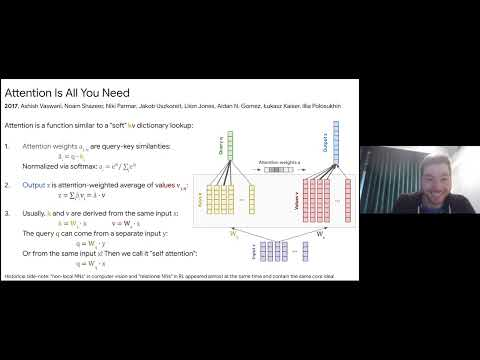

In [27]:
YouTubeVideo('EixI6t5oif0', width=853, height=480) # Transformers with Lucas Beyer, Google Brain

The [Stanford Deep Learning for NLP CS224N (2024 and before) playlist](https://www.youtube.com/playlist?list=PLoROMvodv4rMFqRtEuo6SGjY4XbRIVRd4)

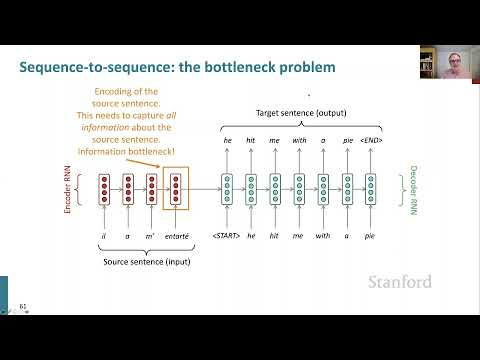

In [28]:
YouTubeVideo('wzfWHP6SXxY', width=853, height=480) #  Stanford CS224N NLP with Deep Learning | Winter 2021 | Lecture 7 - Translation, Seq2Seq, Attention

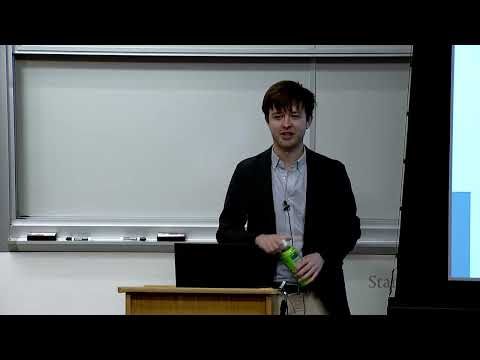

In [29]:
YouTubeVideo('LWMzyfvuehA', width=853, height=480) # Stanford CS224N NLP with Deep Learning | 2023 | Lecture 8 - Self-Attention and Transformers

### Transformers from scratch

[Blog post](https://peterbloem.nl/blog/transformers).

Videos:

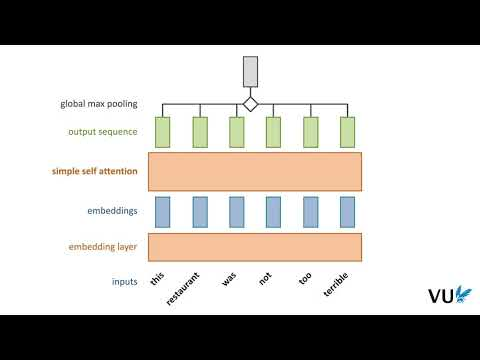

In [30]:
YouTubeVideo('KmAISyVvE1Y', width=853, height=480) #  Lecture 12.1 Self-attention
# The whole playlist: https://www.youtube.com/watch?v=KmAISyVvE1Y&list=PLIXJ-Sacf8u60G1TwcznBmK6rEL3gmZmV

### More

[Stanford CS25 Transformers United](https://www.youtube.com/playlist?list=PLoROMvodv4rNiJRchCzutFw5ItR_Z27CM) covering various research topics & transformers.